In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import text, sequence
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import hstack
import tensorflow as tf
from tensorflow import keras
from normalizer import Normalizer
from results import ModelEvaluation
from joblib import dump

In [2]:
def print_info(msg):
    print("[INFO] "+str(msg))

def print_err(msg):
    print("[ERR] "+str(msg))

def get_balanced_sample(data_frame, n):
    # Separate the DataFrame into two DataFrames based on class
    class_0_df = data_frame[data_frame['label'] == 0]
    class_1_df = data_frame[data_frame['label'] == 1]

    # Calculate the number of samples for each class in the balanced sample
    n_per_class = n // 2  # Divide by 2 to get an equal number of samples for each class

    # Sample n_per_class random rows from each class
    balanced_sample_class_0 = class_0_df.sample(n=n_per_class, random_state=42)
    balanced_sample_class_1 = class_1_df.sample(n=n_per_class, random_state=42)

    # Combine the balanced samples into a single DataFrame
    balanced_sample = pd.concat([balanced_sample_class_0, balanced_sample_class_1])

    # Shuffle the balanced sample
    balanced_sample = balanced_sample.sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_sample


def get_combined_datasets(data_frame_one, data_frame_two):
    combined_df = pd.concat([data_frame_one, data_frame_two])

# Step 2: Shuffle the combined DataFrame
    shuffled_df = combined_df.sample(frac=1).reset_index(drop=True)
    return shuffled_df

def save_model(model, name):
    dump(model, "../FinalModels/models/"+str(name))

def save_vectorizer(vectorizer, name):
    dump(vectorizer, "../FinalModels/vectorizers/"+str(name))

from sklearn.model_selection import StratifiedKFold
import numpy as np

def perform_stratified_cv(model_fn, X, y, n_splits=5, epochhs=3, batch__size = 64):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_scores = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        if hasattr(X_train, "todense"):
            X_train = X_train.todense()
            X_test = X_test.todense()

        model = model_fn(X_train)

        model.fit(X_train, y_train, epochs=epochhs, batch_size=batch__size)

        scores = model.evaluate(X_test, y_test)
        print(f"Fold {fold + 1}: {scores}")

        fold_scores.append(scores)
        del model
    del X
    del y
    del X_train
    del y_train
    del y_test
    del X_test

    print("Average score across folds:", np.mean(fold_scores, axis=0))

In [3]:

CombinedData = pd.read_csv("../FinalModels/datasets/Twitter_News_Reddit.csv")
print_info("The combined dataset is now loaded.")


[INFO] The combined dataset is now loaded.


In [4]:
normalizer = Normalizer()
results = ModelEvaluation()
SAMPLE_SIZE = 20000
print_info("OBJECTS INIT DONE.")

[INFO] OBJECTS INIT DONE.


In [5]:
def Create_MultiLayerNetwrok(train):

    mlp = keras.Sequential([
        keras.layers.Dense(256, activation='relu', input_shape=(train.shape[1],)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    mlp.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    
    return mlp


In [6]:
matrix= normalizer.vectorize(pd.DataFrame({"text": CombinedData["text"].astype("str")}))

[INFO] Trying to create a sparse matrix for text, using an instance of TfIdf_vectorizer
[INFO] Extracting columns containing text from dataframe.
[INFO] Successfully extracted text columns from the dataset.
[INFO] Applying Normalization over text:
[INFO]       - Converting Text into lower case for caseconsistency.
[INFO]       - Extracting only words containing alphabets.
[INFO] Text Normalization is now complete.
[INFO] Fitting the vecotirzer to given text.
[INFO] Transforming the text into a sparse matrix.
[INFO] Sparse Matrix has been successfully created over the text given as input.


In [7]:
print_info("Attempting to split data into train and test sets.")
y = CombinedData["label"].astype("int")
X = matrix.toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42, stratify=y_train)
print_info("Subsets created successfully.")


[INFO] Attempting to split data into train and test sets.
[INFO] Subsets created successfully.


In [8]:
mlp = Create_MultiLayerNetwrok(X_train)
mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               8995328   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9044865 (34.50 MB)
Trainable params: 9044865 (34.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
history = mlp.fit(X_train, 
                       y_train, 
                       epochs=3, 
                       batch_size=128, 
                       validation_data=(X_val, y_val))


Epoch 1/3
338/338 [==============================] - 22s 63ms/step - loss: 0.4910 - accuracy: 0.7622 - val_loss: 0.3897 - val_accuracy: 0.8235
Epoch 2/3
338/338 [==============================] - 19s 57ms/step - loss: 0.2699 - accuracy: 0.8892 - val_loss: 0.3509 - val_accuracy: 0.8494
Epoch 3/3
338/338 [==============================] - 19s 57ms/step - loss: 0.1363 - accuracy: 0.9520 - val_loss: 0.3210 - val_accuracy: 0.8840


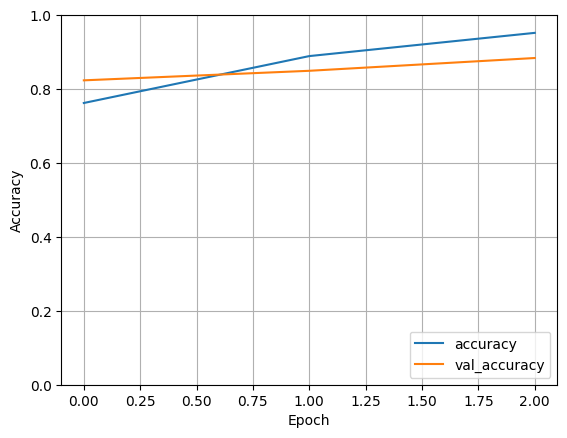

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid()
plt.show()

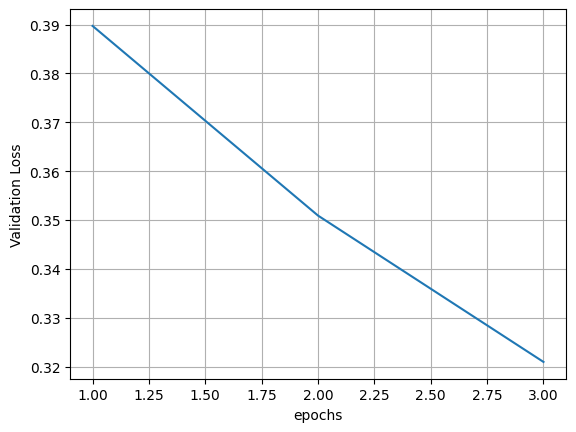

In [11]:
losses = history.history["val_loss"]
plt.plot(range(1,4), losses)
plt.xlabel("epochs")
plt.ylabel("Validation Loss")
plt.grid()
plt.show()


In [12]:
y_pred = mlp.predict(X_test)

y_pred_class = (y_pred >= 0.5).astype(int)
results.classification_report(y_test, y_pred_class)

375/375 [==============================] - 2s 6ms/step
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      6000
           1       0.87      0.90      0.88      6000

    accuracy                           0.88     12000
   macro avg       0.88      0.88      0.88     12000
weighted avg       0.88      0.88      0.88     12000



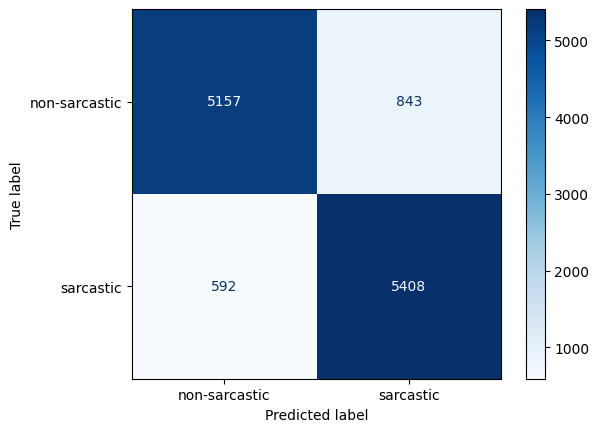

In [13]:
results.get_cm(y_true=y_test, y_pred=y_pred_class)

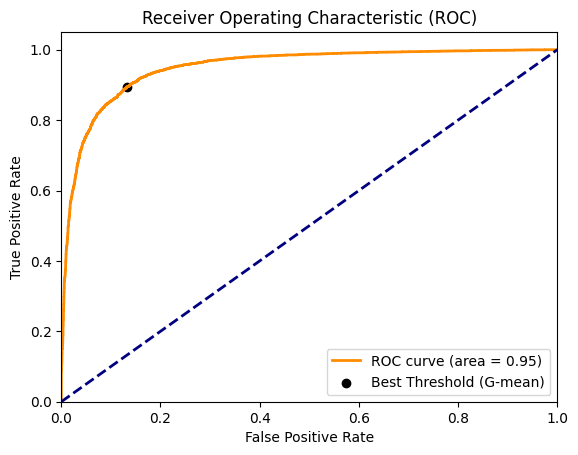

Best Threshold=0.5388


In [14]:
threshold = results.get_roc(y_test, y_pred)